Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 24.9 ms, sys: 0 ns, total: 24.9 ms
Wall time: 24.9 ms
CPU times: user 42.4 ms, sys: 33.3 ms, total: 75.6 ms
Wall time: 37.9 ms


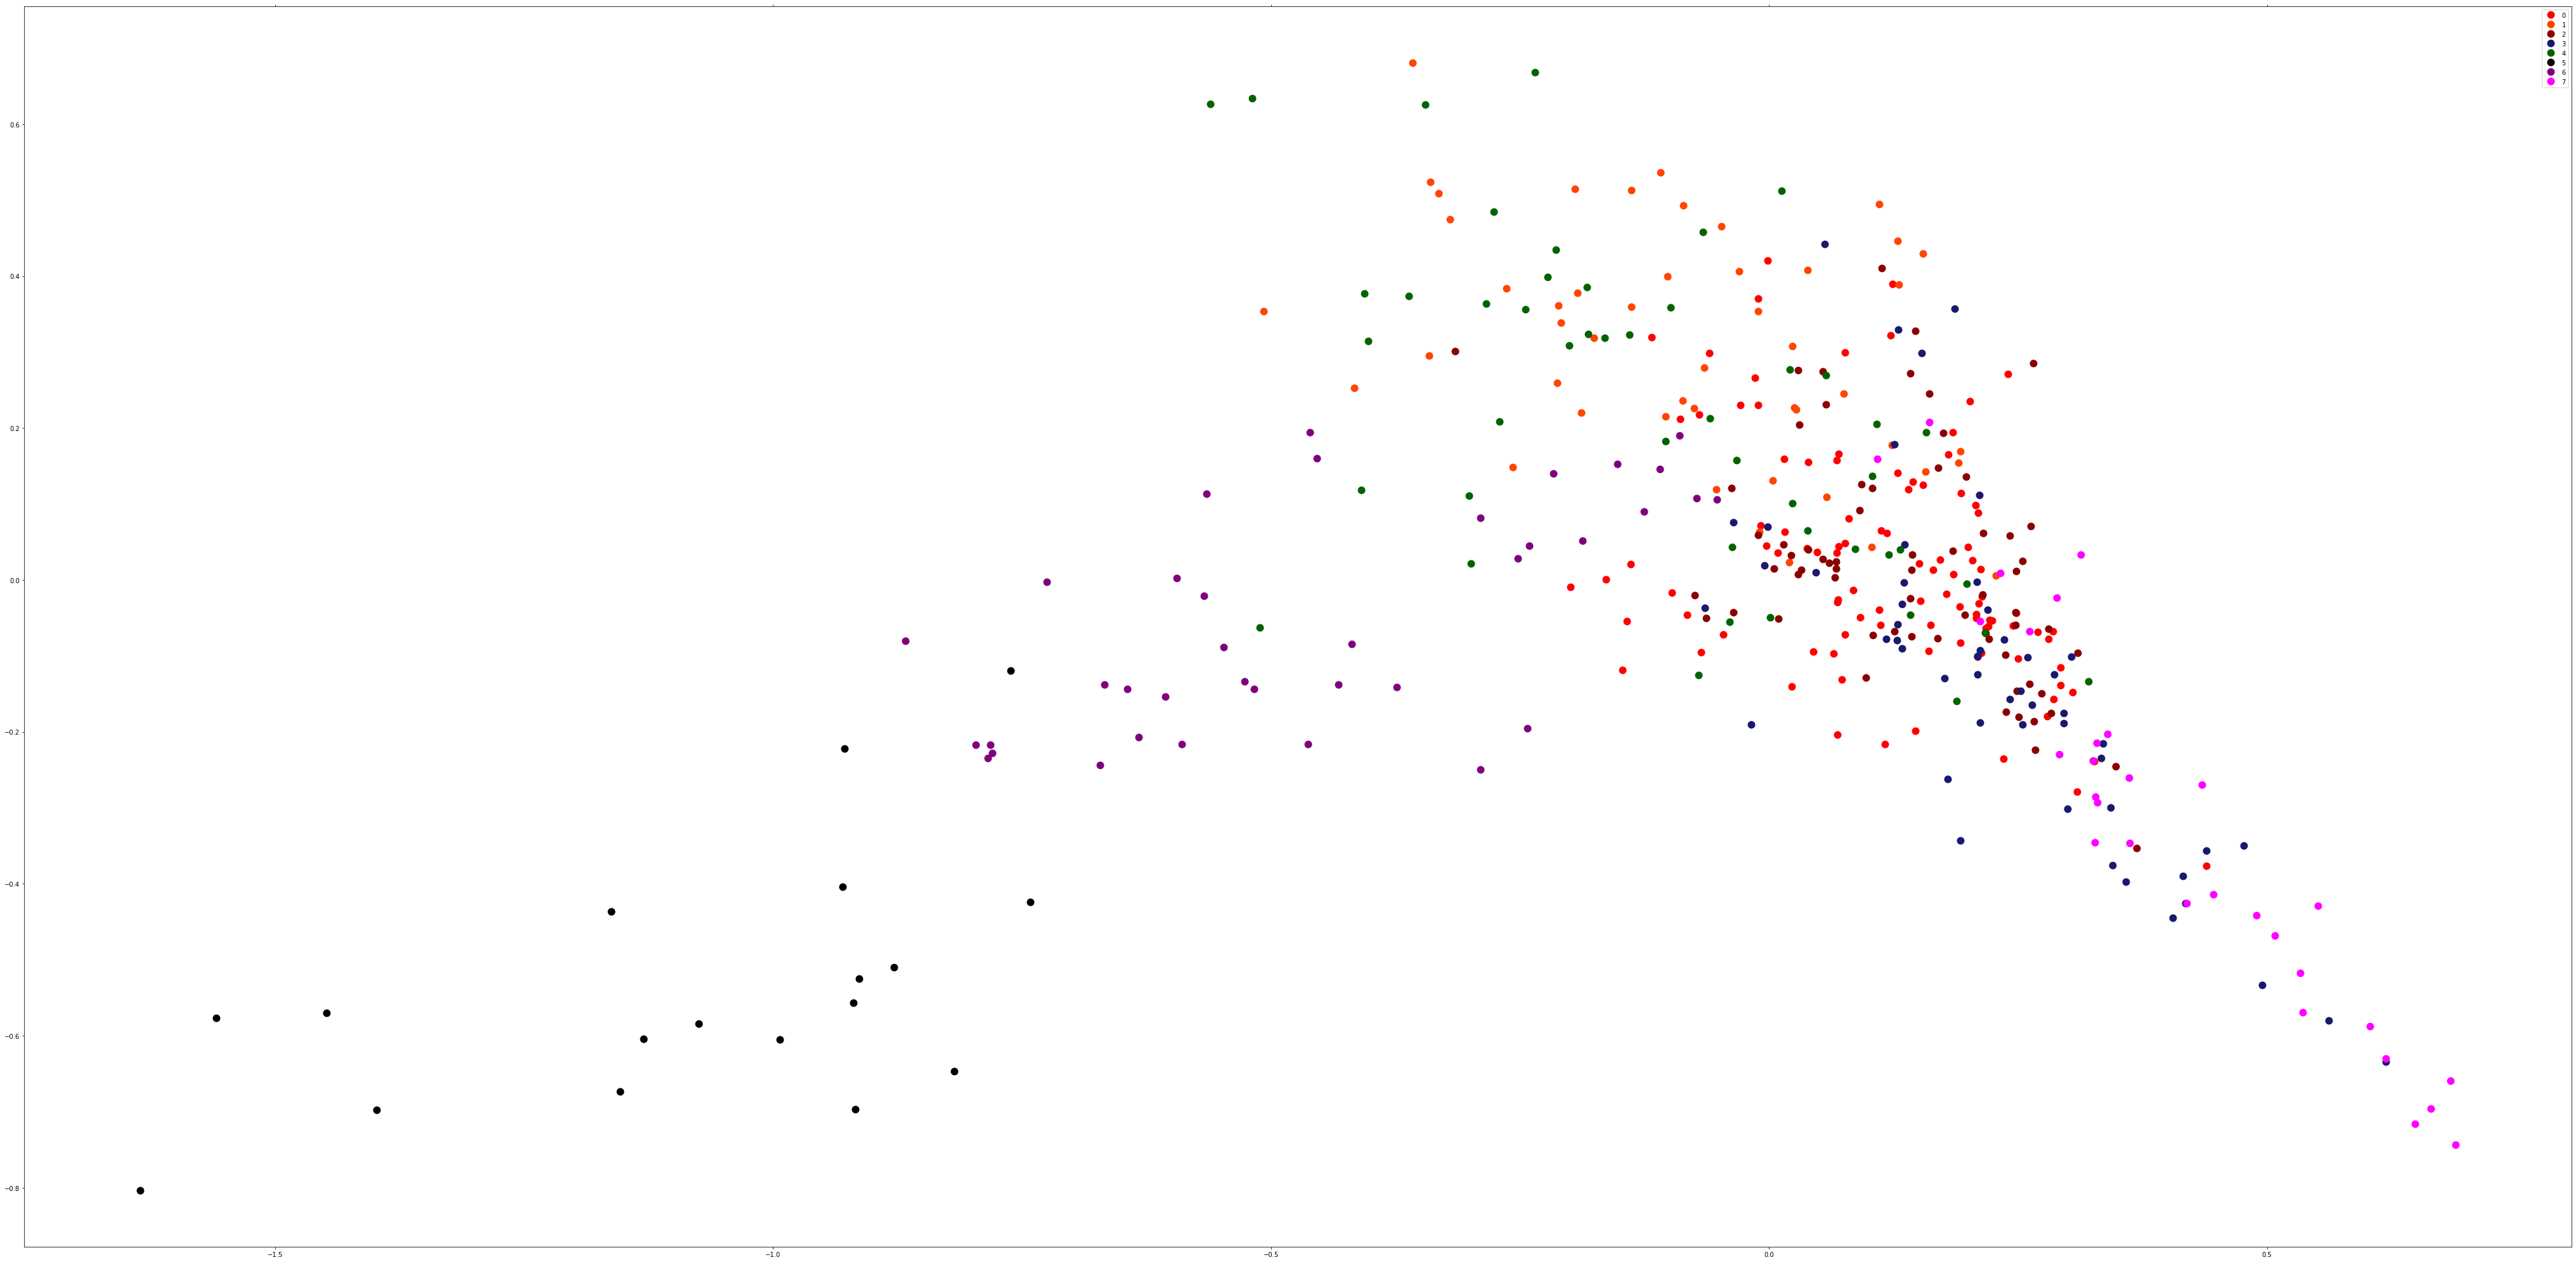

In [2]:
!pip install rutermextract
!pip install pymorphy2

import pandas as pd
import regex as re
import pymorphy2
import random
from matplotlib import rc
import matplotlib.pyplot as plt
from rutermextract import TermExtractor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
import nltk
nltk.download('stopwords')

data = pd.read_csv('/content/accounting_data.csv')
data = data.drop_duplicates(keep='first')

data.loc[:,'News'] = data.loc[:,'Description'].apply(lambda x: ' '.join(re.findall('[а-яё]+', x.lower())))

morph = pymorphy2.MorphAnalyzer()

def lemmatize(txt):
    words = txt.split() 
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res

#data.loc[:,'News'] = data.loc[:,'News'].apply(lambda x: ' '.join(lemmatize(x)))

# извлечение ключевых слов
term_extractor = TermExtractor()

news_terms = []
all_terms = []
for news in data['News']:
  terms = []
  for term in term_extractor(news):
     terms.append(term.normalized)
     for i in range(term.count):
       all_terms.append(term.normalized)
  news_terms.append(terms)

# извлечение трендов по ключевым словам
stopwords = nltk.corpus.stopwords.words('russian')
stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на','россия',\
                  'год','сутки','страна','январь','февраль','март','апрель','май','июнь',\
                  'июль','август','сентябрь','октябрь','ноябрь','декабрь'])

terms = [word for word in all_terms if not word in stopwords]

key_words =  ' '.join(terms)
trends = []
for term in term_extractor(key_words):
  trends.append([term.normalized, term.count])

# Кластеризация новостей

news_keyword = []
for keywords in news_terms:
  news_keyword.append(' '.join(keywords))

n_featur=1000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=stopwords,
                                 use_idf=True, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(news_keyword)

num_clusters = 8

# Метод к-средних
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
idx = km.fit(tfidf_matrix)
clusterkm = km.labels_.tolist()

frame = pd.DataFrame(news_keyword, index = [clusterkm])

#k-means
out = { 'title': news_keyword, 'cluster': clusterkm }
frame1 = pd.DataFrame(out, index = [clusterkm], columns = ['title', 'cluster'])

dist = 1 - cosine_similarity(tfidf_matrix)

# Метод главных компонент - PCA
icpa = IncrementalPCA(n_components=2, batch_size=16)
get_ipython().magic('time icpa.fit(dist) #demo =')
demo2 = icpa.transform(dist)
xs, ys = demo2[:, 0], demo2[:, 1]

# PCA 3D
icpa = IncrementalPCA(n_components=3, batch_size=16)
get_ipython().magic('time icpa.fit(dist) #demo =')
ddd = icpa.transform(dist)
xs, ys, zs = ddd[:, 0], ddd[:, 1], ddd[:, 2]

# цвета кластеров
cluster_colors = {0: '#FF0000', 1: '#FF4500', 2: '#8B0000',  3: '#191970', 4: '#006400', 5: '#000000', 6: '#800080', 7: '#ff00ff',}
#имена кластерам
cluster_names = {0: '0',  1: '1', 2: '2',  3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}
#matplotlib inline

#создаем data frame, который содержит координаты (из PCA) + номера кластеров и сами запросы
df = pd.DataFrame(dict(x=xs, y=ys, label=clusterkm, title=news_keyword)) 
#группируем по кластерам
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(72, 36))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(        axis= 'y',         
        which='both',     
        left='off',      
        top='off',       
        labelleft='off')

#показать легенду только 1 точки
ax.legend(numpoints=1) 

plt.show() 
plt.close()